In [1]:
import struct
import librosa
import numpy as np

class WavFileHelper():
    
    def read_file_properties(self, filename):

        wave_file = open(filename,"rb")
        
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]
        
        wave_file.close()

        # Load the audio file with librosa
        y, sr = librosa.load(filename, sr=None, mono=True)  # Load as mono

        # Compute RMS of the audio signal using librosa
        rms = librosa.feature.rms(y=y)[0]
        avg_rms = np.mean(rms)  # Average RMS over time if needed
        
        return (num_channels, sample_rate, bit_depth, avg_rms)


In [2]:
#Import and install dependencies
# tensorflow_io 0.28 is compatible with TensorFlow 2.11
# Python 3.10* needed.
#! pip install tensorflow==2.11.* tensorflow-io==0.31.0 matplotlib

In [3]:
# imports and constants
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import pandas as pd
import librosa
import librosa.display
import numpy as np
from scipy.io import wavfile as wav
import IPython.display as ipd

wavfilehelper = WavFileHelper()

DATA_DIR = 'D:\Code\ProjectsPython\ML_TrainingGround\ML_Audio\data'
METADATA = os.path.join(DATA_DIR, "UrbanSound8K", "metadata", "UrbanSound8K.csv")
AUDIO_DIR = os.path.join(DATA_DIR, "UrbanSound8K", "audio")

<h3><i>Observe the Dataset</i></h3>

In [4]:
AUDIO01 = os.path.join(AUDIO_DIR, "fold1/101415-3-0-2.wav")
AUDIO02 = os.path.join(AUDIO_DIR, "fold10/2937-1-0-0.wav")

<p><b>Dataset metadata</b></p>

In [5]:
df = pd.read_csv(METADATA)
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


<p><b>Class distribution</b></p>

In [6]:
print(df["class"].value_counts())

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64


**Diversity in sample properties**
*  Number of channels  
*  Sample rates
*  Bit depths

In [7]:
audiodata = []
for index, row in df.iterrows():
    
    file_name = os.path.join(AUDIO_DIR,'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)
    # Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth', 'rms'])

In [8]:
audiodf.head()

# num of channels 
print(audiodf.num_channels.value_counts(normalize=True))

# sample rates 
print(audiodf.sample_rate.value_counts(normalize=True))

# bit depth
print(audiodf.bit_depth.value_counts(normalize=True))

# RMS
print(audiodf.rms.describe())

num_channels
2    0.915369
1    0.084631
Name: proportion, dtype: float64
sample_rate
44100     0.614979
48000     0.286532
96000     0.069858
24000     0.009391
16000     0.005153
22050     0.005039
11025     0.004466
192000    0.001947
8000      0.001374
11024     0.000802
32000     0.000458
Name: proportion, dtype: float64
bit_depth
16    0.659414
24    0.315277
32    0.019354
8     0.004924
4     0.001031
Name: proportion, dtype: float64
count    8732.000000
mean        0.069614
std         0.066487
min         0.000176
25%         0.024116
50%         0.051834
75%         0.092457
max         0.771243
Name: rms, dtype: float64


### Preprocessing with Librosa
* Resample to common sample rate
* Bit-depth Normalization
* Mix-down to mono channel

In [9]:
# Resample
filename = AUDIO01

librosa_audio, librosa_sample_rate = librosa.load(filename) 
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate) 

Original sample rate: 48000
Librosa sample rate: 22050


In [10]:
#Bit-depth 
# Librosa’s load function will also normalise the data so it's values range between -1 and 1. This removes the complication of the dataset having a wide range of bit-depths.

print('Original audio file min~max range:', np.min(scipy_audio), 'to', np.max(scipy_audio))
print('Librosa audio file min~max range:', np.min(librosa_audio), 'to', np.max(librosa_audio))

Original audio file min~max range: -27967 to 26427
Librosa audio file min~max range: -0.8536738 to 0.8049574


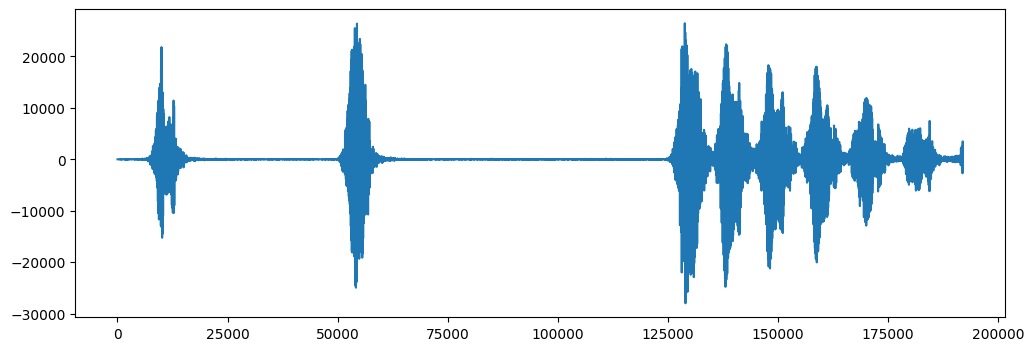

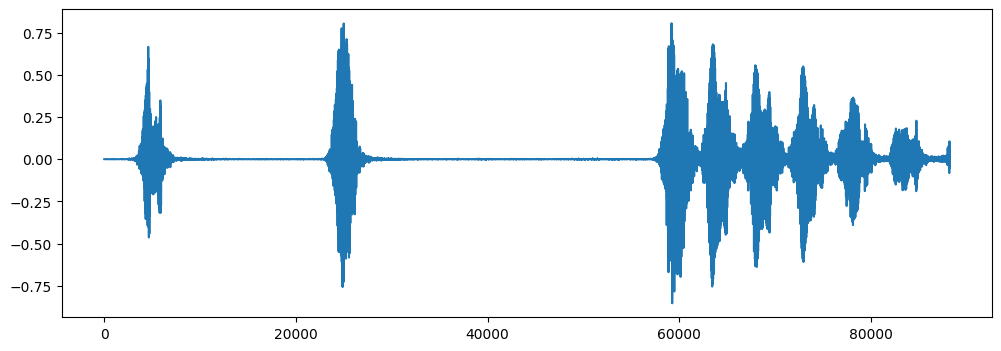

In [11]:
# Mix down to mono

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

# Librosa audio with channels merged 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio)

# ______________________________________________________________________________
## <i>FEATURE EXTRACTION:</i>

### Option 1
**Extract MFCCs**

(40, 173)


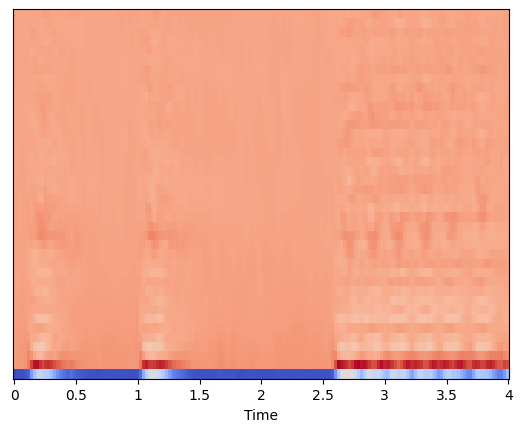

In [12]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

In [13]:
#! pip install resampy
max_pad_len = 174

def extract_mfccs(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
         
    return mfccs

In [14]:
features = []

# Iterate through each sound file and extract the features 
for index, row in df.iterrows():
    
    file_name = os.path.join(AUDIO_DIR,'fold'+str(row["fold"])+'\\',str(row["slice_file_name"]))
    class_label = row["class"]
    data = extract_mfccs(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

d:\Code\ProjectsPython\ML_TrainingGround\ML_Audio\.venv\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
d:\Code\ProjectsPython\ML_TrainingGround\ML_Audio\.venv\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
d:\Code\ProjectsPython\ML_TrainingGround\ML_Audio\.venv\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


Finished feature extraction from  8732  files


In [15]:
featuresdf.head()

,feature,class_label
0,"[[-335.0899, -176.70966, -98.33869, -65.15997,...",dog_bark
1,"[[-492.1376, -455.06793, -449.95038, -444.2668...",children_playing
2,"[[-496.66345, -471.2096, -479.95898, -485.4825...",children_playing
3,"[[-447.43988, -412.1046, -408.45084, -408.2987...",children_playing
4,"[[-473.87814, -438.34927, -442.38864, -441.715...",children_playing


In [19]:
featuresdf.iloc[0]['feature'].shape

(40, 174)

#### <i>END OF FEATURE EXTRACTION</i>
# ______________________________________________________________________________

**Convert the data and labels**
<p>We will use sklearn.preprocessing.LabelEncoder to encode the categorical text data into model-understandable numerical data.</p>
<p><i>Meaning, that every class has a column, which is either 0 or 1</i></p>

In [23]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

### Split the dataset

In [24]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

<b>Store the preprocessed data</b>

In [25]:
### store the preprocessed data for use in the next notebook

%store x_train 
%store x_test 
%store y_train 
%store y_test 
%store yy 
%store le

Stored 'x_train' (ndarray)
Stored 'x_test' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)
Stored 'yy' (ndarray)
Stored 'le' (LabelEncoder)
